<a href="https://colab.research.google.com/github/jorisgauliard/windturbine/blob/main/presentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adjustable Incidence Vertical Windturbine
### Power Calculation and Optimal Incidence Definition

I collaborated with a windturbine compagny to compare experimental findings with a theoretical power calculation.

The windturbine technology is patented.

All the dimensions that are used here are fictional.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definition of the incidence and power fucntions

In [5]:
def incidence(Io,threshold,s,type=2):
    
    # calcul préalables a partir des paramètres d'entrée
    
    a = np.linspace(0, 2*np.pi,s)        # definition de l'angle
    I = np.zeros(s)                      # creation d'une liste vide pour la variable incidence

    if threshold >= 1:                   # threshold >= 1 equivalent a allure carrée
        type = 1
        
    # creation de la base incidence a allure carree
    
    for i in range(s):                   # on parcourt sur s iteration

        if np.cos(a[i]) > 0:             # condition sur l'angle
            I[i] = Io                    # attribution de la valeure I0 a I si condition validée
        elif np.cos(a[i]) == 0:
            I[i] = 0                     # attribution de la valeure 0 a I si condition validée
        else:
            I[i] = -Io                   # attribution de la valeure -I0 a I si condition validée

    # retour de I si le choix est type 1 
    
    if type == 1:                            # condition 1
        
        return I                             # retour de I et sortie de la fonction incidence
    
    # calcul de I si choix 2
    
    elif type == 2:
        
        A0 = np.arcsin(threshold)                # calcul de l'angle de seuil in
        A1 = np.pi / 2 + np.arccos(threshold)    # calcul de l'angle de seuil out
        T = 2 * (A1 - A0)                        # periode de la sinusoïde entre in et out
        f = 1 / T                                # frequence de la sinusoïde entre in et out
        omega = 2 * np.pi * f                    # vitesse angulaire de la sinusoïde entre in et out
        phi1 = - omega*A0 + np.pi/2              # dephasage sur la partie haute a cos positif
        phi2 = - omega*(A0+np.pi) - np.pi/2      # dephasage sur la partie haute a cos negatif
        
        for i in range(s):

            if np.sin(a[i]) > threshold:
                I[i] = Io * np.sin(omega * a[i] + phi1)

            elif np.sin(a[i]) < -threshold:
                I[i] = Io * np.sin(omega * a[i] + phi2)
                
        return I
                
    else:
        
        print("Type must be 1 or 2 and is now set as",type)

In [18]:
def power(Vr, Rv, R, l, L, I0, threshold, s):
    
    #Calculated parameters
    Vd = Rv * Vr
    w = Vd / (2 * np.pi * R) # vitesse de rotation en m/s
    # Cd & Cl table import
    Coeffs = pd.read_excel(r'coeff.xlsx')
    Coeffs.Alpha[1]
    
    #variables names initialisation
    variables_list = ['a', 'Theta', 'Tabsolue', 'vent_apparent','Portance', 'Trainee' , 'Cl', 'Cd', 'Couple_moteur', 'Couple_resistant', 'Couple_resultant', 'Travail_resultant']
    variables_dict = {}
    for x in variables_list:
        variables_dict[x] = np.linspace(0, 2*np.pi,s)
    
    I = incidence(I0, threshold, s) #application de la focntion incidence
    
    # calculation of parameters
    for i in range(s):
        variables_dict['vent_apparent'][i] = np.sqrt(Vr ** 2 + Vd ** 2 - 2 * Vr * Vd * np.cos(np.pi / 2 + variables_dict['a'][i]))
        variables_dict['Theta'][i] = np.arcsin(Vr / variables_dict['vent_apparent'][i] * np.sin(variables_dict['a'][i] - np.pi / 2))
        variables_dict['Tabsolue'][i] = np.abs(variables_dict['Theta'][i])
        variables_dict['Cl'][i] = Coeffs.Cl[(np.abs(Coeffs.Alpha - I[i])).argmin()]
        variables_dict['Cd'][i] = Coeffs.Cd[(np.abs(Coeffs.Alpha - I[i])).argmin()]
        variables_dict['Portance'][i] = 1 / 2 * 1.225 * variables_dict['vent_apparent'][i] ** 2 * L * l * variables_dict['Cl'][i]
        variables_dict['Trainee'][i] = 1 / 2 * 1.225 * variables_dict['vent_apparent'][i] ** 2 * L * l * variables_dict['Cd'][i]
        variables_dict['Couple_moteur'][i] = np.abs(variables_dict['Portance'][i] * np.sin(variables_dict['Tabsolue'][i])) * R
        variables_dict['Couple_resistant'][i] = variables_dict['Trainee'][i] * np.cos(variables_dict['Tabsolue'][i]) * R
        variables_dict['Couple_resultant'][i] = variables_dict['Couple_moteur'][i] - variables_dict['Couple_resistant'][i]
        variables_dict['Travail_resultant'][i] = variables_dict['Couple_resultant'][i] * 2 * np.pi / s
    
    travail_total = sum(variables_dict['Travail_resultant'])
    puissance = 4 * travail_total * w
    puissance_surfacique = puissance / (2 * L * R)
    
    return [w,puissance, puissance_surfacique]

# Power Calculation
---
## Visualisation de l'incidence

La fonction **incidence** permet de définir l'incidence réelle : l'angle formé entre une pale et le vent apparent.
4 paramètres en entrée sont nécessaires :
- **I0** *l'incidence optimale*, égale à 7° dans cette étude
- **threshold** *le seuil ajustable*, valeure subjective entre 0 et 1
- **s** *le nombre d'échantillons*, au choix
- **type** *l'allure (carrée ou sinusoïdale)*, sinusoïdal par défaut

In [8]:
I0 = 10                  # incidence optimale
threshold = 0.8          # seuil
s = 1000                 # nombre d'échantillons

On définit une variable **angle** représentant l'angle au vent réel, sur **s** échantillons

In [9]:
angle = np.linspace(0, 2*np.pi, s)

Appel de la fonction **incidence**

In [10]:
incidence_finale = incidence(I0, threshold, s)

Visualisation de l'incidence

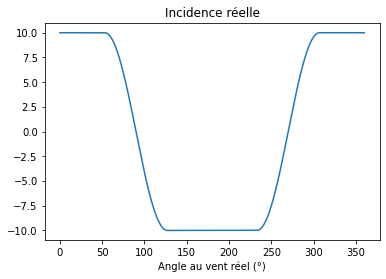

In [11]:
plt.figure()                                    # création d'une figure
plt.title('Incidence réelle')                   # titre du graphique
plt.xlabel('Angle au vent réel (°)')            # label de l'axe x
plt.plot(180 / np.pi * angle, incidence_finale) # tracé avec angle en degrés
plt.show()                                      # affichage

Il est intéressant de visualiser l'incidence pour différentes valeures de seuil comme ci-dessous :

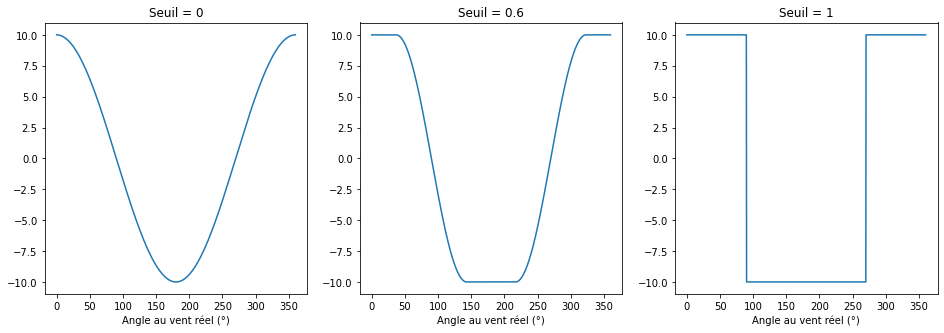

In [12]:
plt.figure(figsize=(16,5))

plt.subplot(1, 3, 1)
plt.title('Seuil = 0')                  
plt.xlabel('Angle au vent réel (°)')            
plt.plot(180 / np.pi * angle, incidence(I0, 0, s))

plt.subplot(1, 3, 2)
plt.title('Seuil = 0.6')                  
plt.xlabel('Angle au vent réel (°)')            
plt.plot(180 / np.pi * angle, incidence(I0, 0.6, s))

plt.subplot(1, 3, 3)
plt.title('Seuil = 1')                  
plt.xlabel('Angle au vent réel (°)')            
plt.plot(180 / np.pi * angle, incidence(I0, 1, s))

plt.show()

De manière idéale on cherche a tendre vers un seuil de 1 mais cela est, de manière pratique, impossible a mettre en oeuvre pour des raisons mécaniques. En effet cela entrainerait un changement de bord brutal.
On utilise donc un seuil choisit arbitrairement à 0.6 pour la suite de l'étude.

## Calcul de la puissance

In [ ]:
from function_wind import power

On définit la vitesse du vent réel ainsi que le ratio entre vent réel et vent due au mouvement de rotation

In [13]:
Vr = 6.0 #real wind in m/s
Rv = 2.0 # linear/real wind ratio

Puis on définit les parametres dimentionelles de l'eolienne

In [14]:
R = 1.15  #radius
l = 0.25  #chord
L = 2     #longueur pale

Pour ensuite call la fonction power

In [19]:
output = power(Vr, Rv, R, l, L, I0, threshold, s)
print('La vitesse de rotation est de ', int(output[0] * 60), 'tr/min')
print('La puissance est de ', int(output[1]), 'W')
print('La puissance surfacique est de ', int(output[2]), 'W/m2')

La vitesse de rotation est de  99 tr/min
La puissance est de  657 W
La puissance surfacique est de  143 W/m2


## Visualisation
On peut étudier la puissance en fonction de différents paramètres

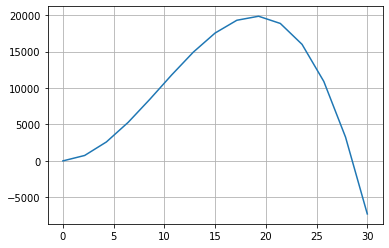

In [20]:
Rvi = 0
Rvf = 30
s2 = 15
Rv = np.linspace(Rvi,Rvf,s2)
Power_variable = np.linspace(Rvi,Rvf,s2)

for i in range(s2):
    Power_variable[i] = power(Vr, Rv[i], R, l, L, I0, threshold, s)[1]

fig, ax = plt.subplots()
ax.plot(np.linspace(Rvi,Rvf,s2),Power_variable)
ax.grid()